In [1]:
import numpy as np
import pandas as pd
import gzip 
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nbextensions
%matplotlib inline
#http://jmcauley.ucsd.edu/data/amazon/
#CDs and Vinyl 5-core

In [2]:
a = np.load('merged_album_data.pkl')
#null album titles are no use for us
a = a[~(a['title'].isnull())]
a = a[['reviewerID', 'asin', 'title']].drop_duplicates(subset=['reviewerID', 'title'])

In [3]:
users_list = a['reviewerID'].unique()
users_index = {user: idx for idx, user in enumerate(users_list)}
#tranform each prod into an index
prod_list = a['title'].unique()
prod_index = {prod: idx for idx, prod in enumerate(prod_list)}
a = a[['reviewerID', 'asin','title']]
a['reviewerID'] = a['reviewerID'].apply(lambda x: users_index[x]).astype('int')
a['prodID'] = a['title'].apply(lambda x: prod_index[x]).astype('int')
music_index = dict(zip(a['title'], a['prodID']))
a = a[['reviewerID', 'prodID']]
a = a.drop_duplicates(subset=['reviewerID', 'prodID'])
a['purchase_flag'] = 1

# Generate negative samples

In [6]:
#function used from https://medium.com/@2j/negative-sampling-in-numpy-18a9ad810385
def negsamp_vectorized_bsearch(pos_inds, n_items, n_samp=32):
    raw_samps = np.random.randint(0, n_items, size=n_samp)
    ss = np.searchsorted(pos_inds, raw_samps)
    pos_mask = raw_samps == np.take(pos_inds, ss, mode='clip')
    neg_inds = raw_samps[~pos_mask]
    return neg_inds

In [7]:
#shrink dataframe so that we have one row per reviewer, with products as an array
#n_samp is another hyperparameter that would be good to optimise. Perhaps we could just look at popular products?
a_shrink = a.groupby('reviewerID')['prodID'].apply(np.array).rename('prodIDs').reset_index()
a_shrink['negative_prodIDs'] = a_shrink['prodIDs'].apply(lambda x: negsamp_vectorized_bsearch(x, max(prod_index.values()), n_samp=2*len(x)))

In [8]:
s = a_shrink.apply(lambda x: pd.Series(x['negative_prodIDs']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'prodID'
a_shrink = a_shrink.drop(['prodIDs','negative_prodIDs'], axis=1).join(s)
a_shrink['purchase_flag'] = 0
a = pd.concat([a[['reviewerID', 'prodID', 'purchase_flag']], a_shrink], ignore_index=True)
a.head()

,reviewerID,prodID,purchase_flag
0,0,0.0,1
1,1,0.0,1
2,2,0.0,1
3,3,0.0,1
4,4,0.0,1


In [9]:
a = a.sort_values(['reviewerID', 'prodID'], ascending=[True, True]).reset_index()[['reviewerID', 'prodID', 'purchase_flag']]

In [10]:
a.head()

,reviewerID,prodID,purchase_flag
0,0,0.0,1
1,0,2932.0,0
2,0,4421.0,1
3,0,12640.0,0
4,0,19290.0,0


In [4]:
# a.to_pickle('merged_album_data_final_no_genre')
a = np.load('merged_album_data_final_no_genre')

# Build model and train

In [11]:
from torch.utils.data import Dataset, DataLoader
#create a custom data dataset / dataloader
class music_dataset(Dataset):

    def __init__(self):
        xy = np.load('merged_album_data_final_no_genre')
        self.u = np.array(xy.iloc[:,0:1])
        self.p = np.array(xy.iloc[:,1:2])
        self.up = np.array(xy.drop(xy.columns[2],axis=1))
        self.y = np.array(xy.iloc[:,2:])
    def __len__(self):
        return len(self.up)

    def __getitem__(self, idx):
        return self.up[idx], self.y[idx]

In [5]:
#we need weights for the: Users, products (music), bias for Users, and bias for products (music).
#so 4 parameters.
from torch.nn import Module, Embedding, BCELoss
from torch.optim import *
from torch.autograd import Variable
import torch 

def get_embs(ni, nf):
    "Create an embedding layer."
    emb = torch.nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    emb.weight.data.uniform_(0,0.05)
    return emb

class EmbeddingModel(Module):
    #initiate the weights and biases of user and product.
    #these need to be leared through forward pass
    def __init__(self, n_dims, n_users, n_items):
        super(EmbeddingModel, self).__init__()
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [get_embs(*o) for o in [
            (n_users, n_dims), #user weights
            (n_items, n_dims), #product weights
            (n_users,1), #user bias
            (n_items,1)]] #product bias
    def forward(self, users, items):
        matmul = self.u_weight(users)* self.i_weight(items)
        out = matmul.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        #run output through a sigmoid
        return torch.sigmoid(out)

In [6]:
from torch.optim.lr_scheduler import _LRScheduler
class CyclicLR(_LRScheduler):
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))            
        return base_lr + delta
        
    return scheduler 

def cosine(t_max, eta_min=0):  
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler


In [152]:
#we have a simple architecture now (embeddings). 
#we need to build a learner to train the model with
# Loop over epochs
#https://github.com/devforfu/pytorch_playground/blob/master/movielens.ipynb
import math
import torch.nn.functional as F
df_new = music_dataset()
ds = DataLoader(df_new, batch_size=64, shuffle=True)

model = EmbeddingModel(n_dims=40, n_users=len(np.unique(df_new.u)),
           n_items=len(np.unique(df_new.p)))
lr=5e-3
loss_func = BCELoss()
max_epochs = 2
optimizer = Adam(model.parameters(),lr=lr,weight_decay=1e-5)
iterations_per_epoch = len(ds)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))
optimizer.zero_grad()
full_loss_df = []
loss_values = []
for epoch in range(max_epochs):
    # Training
    loss= 0.
    for local_index, local_batch in enumerate(ds, 0):
        loss= 0.
        #pass in the indices of the batch user and prod 
        output = model.forward(local_batch[0][:,0:1].squeeze(1).long(), local_batch[0][:,1:2].squeeze(1).long())
        #compare outputs of batch with n=64 to label and compute the loss
        labels = local_batch[1].float()
        #calculate the loss
        a = model.u_weight(local_batch[0][:,0:1].squeeze(1).long()[0]).clone()
        loss = loss_func(output, labels.squeeze(1))
        scheduler.step()
        #update the parameters using backpropogation
        loss.backward()
        optimizer.step()
        b = model.u_weight(local_batch[0][:,0:1].squeeze(1).long()[0]).clone()
        #check if it's trained. if it hasn't then stop the training
        assert torch.equal(a.data, b.data)==False
        optimizer.zero_grad()
        loss_values.append(loss.data.item())
        if (len(loss_values) % 100 == 0) | (len(loss_values) == 1):
            print(loss.data.item())

    #load full dataset and run forward pass
    output_full = Variable(model.forward(torch.tensor(df_new.up[:,0:1].squeeze(1)).long(),
                                 torch.tensor(df_new.up[:,1:2].squeeze(1)).long()), requires_grad=False)
    full_loss = loss_func(output_full, Variable(torch.tensor(df_new.y).float().squeeze(1)))        #calculate the loss
    full_loss_df.append(full_loss.data.item())    

0.6985642910003662
0.6856696009635925
0.6475222110748291
0.7201673984527588
0.6505962014198303
0.5592682361602783
0.6675215363502502
0.6794180274009705
0.6650784015655518
0.5420235395431519
0.5913771986961365
0.6471108198165894
0.6252194046974182
0.658309817314148
0.60185706615448
0.6368136405944824
0.5185902714729309
0.6065595746040344
0.5565740466117859
0.5480939149856567
0.5912162065505981
0.5625611543655396
0.6747888326644897
0.6204331517219543
0.5588315725326538
0.5963636636734009
0.5866166949272156
0.5327626466751099
0.5914582014083862
0.5689964294433594
0.6040873527526855
0.691055178642273
0.6297612190246582
0.6609615087509155
0.5465720295906067
0.5600336790084839
0.568292498588562
0.5567008852958679
0.6060009598731995
0.59093177318573
0.5493320226669312
0.5169522166252136
0.5457373261451721
0.5828155875205994
0.6113525032997131
0.6144486665725708
0.5834595561027527
0.5167630314826965
0.5106644034385681
0.4873962998390198
0.5970523953437805
0.5566437840461731
0.6341115236282349


([<matplotlib.lines.Line2D at 0x2784f9537b8>], 29321)

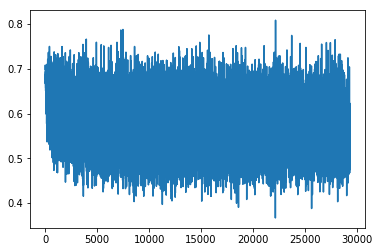

In [157]:
plt.plot(loss_values), len(loss_values)

In [7]:
#load the pre-trained model from above
model = torch.load('dotprod_scratch_binary')

In [8]:
title_index = {v: k for k, v in music_index.items()}
a['title'] = a['prodID'].apply(lambda x: title_index[x])
a.head()

,reviewerID,prodID,purchase_flag,title
0,0,0.0,1,Goodbye Worries
1,0,4421.0,1,Verdi: Requiem
2,0,4485.0,0,"Complete Beethoven Edition, Vol. 1: Symphonies"
3,0,4539.0,0,Do Or Die
4,0,23362.0,1,Handel: Alcina


# Album embedding visual

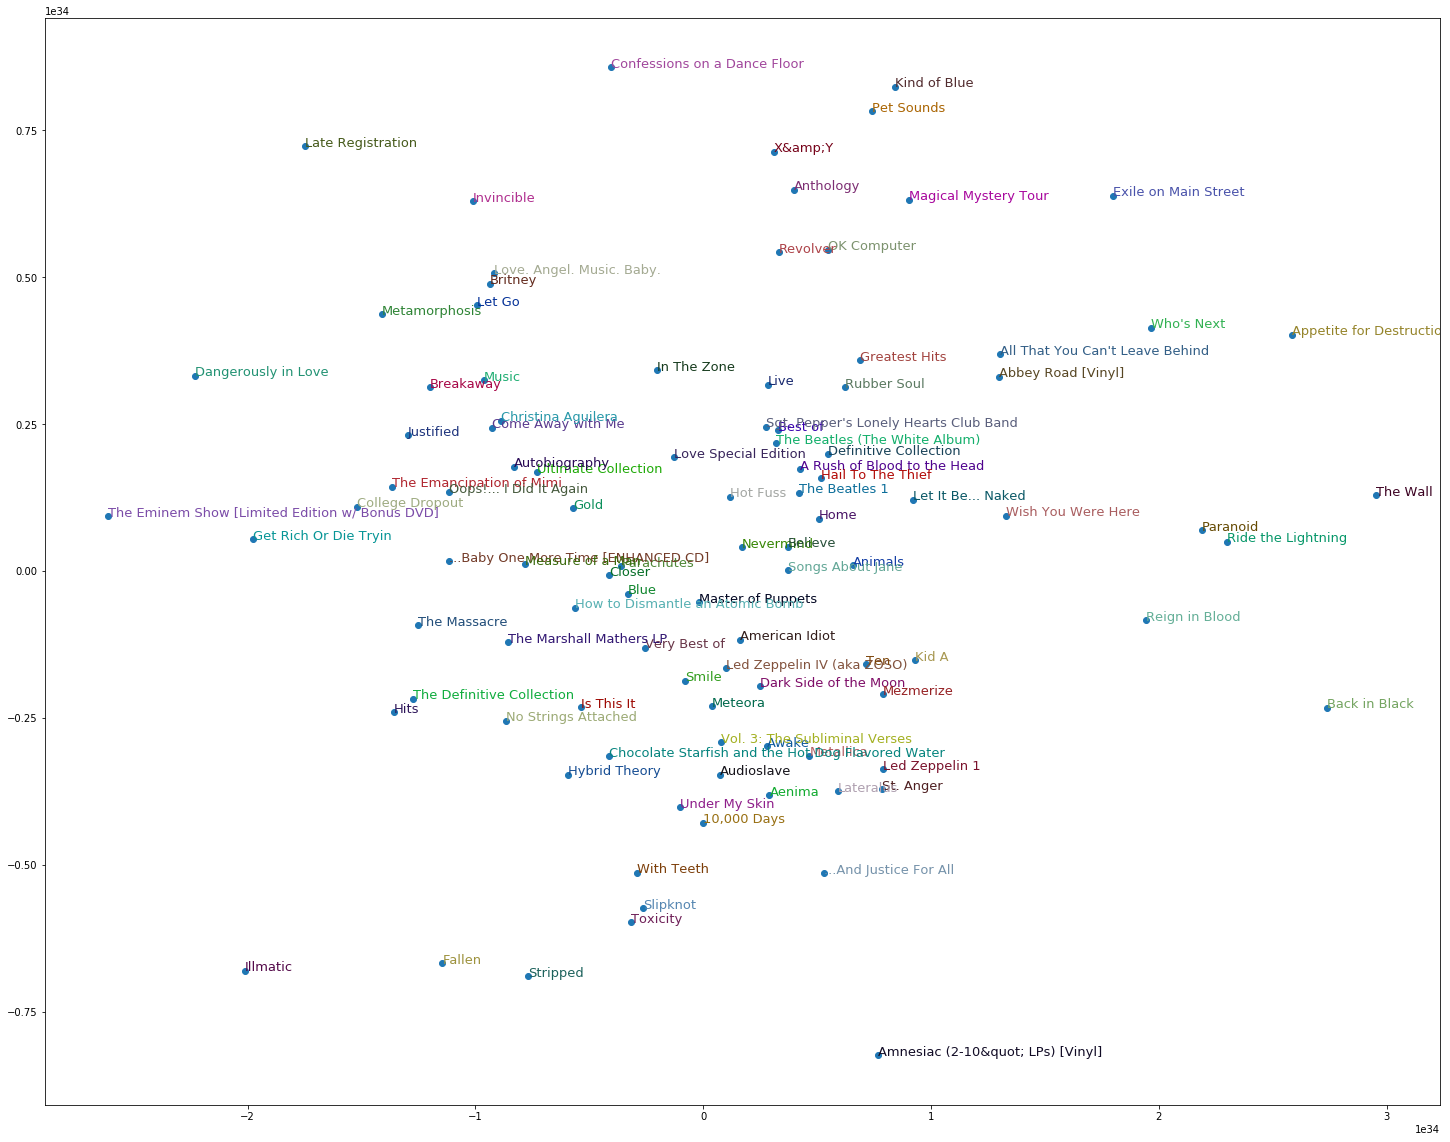

In [13]:
# music_index = dict(zip(df_music['title'], df_music['prodID']))
items_w = model['i_weight.weight']
#from fastai - torch pca
def _pca(x, k=2):
    "Compute PCA of `x` with `k` dimensions."
    x = x-torch.mean(x,0)
    U,S,V = torch.svd(x.t())
    return torch.mm(x,U[:,:k])
torch.Tensor.pca = _pca

def generate_embedding_plot(top=500):
    g = a.groupby('title')['purchase_flag'].count()
    #grab top music
    top_music = g.sort_values(ascending=False).index.values[:top]
    top_music_w = items_w[[music_index[x] for x in top_music.tolist()]]
    #reduce the dimensions from 40 to 2
    top_music_w_pca = top_music_w.detach().pca(2)*10e34
    fac0,fac1 = top_music_w_pca.t()
    music_comp = [(f, i) for f,i in zip(fac0, top_music)]
    
    #produce plot
    idxs = np.random.choice(len(top_music), 300, replace=False)
    idxs = list(range(100))
    X = fac0[idxs]
    Y = fac1[idxs]
    plt.figure(figsize=(25,20))
    plt.scatter(X, Y,clip_on=True)
    for i, x, y in zip(top_music[idxs], X, Y):
        plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=13,clip_on=True)
generate_embedding_plot()    
plt.savefig('embeddings.png', dpi=300)

# Cosine similarity of albums

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = pd.DataFrame(cosine_similarity(
            X=model['i_weight.weight']),
            index=list(music_index.keys()))
similarity_matrix.columns = list(music_index.keys())

C:\Users\miah.stewart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\extmath.py:91: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(norms, norms)


In [26]:
def find_similar_albums(album, n):
    similar_items = pd.DataFrame(similarity_matrix.loc[album])
    similar_items.columns = ['score']
    similar_items = similar_items.sort_values('score', ascending=False)
    similar_items = similar_items.head(n).reset_index()
    similar_items = similar_items.rename(index=str, columns={'index': 'album'})
    return similar_items[1:]

In [31]:
find_similar_albums('Britney', 10)

,album,score
1,Someone to Call My Lover,0.992629
2,Live Like You Were Dying,0.992043
3,Not That Kind,0.991261
4,American Idol Greatest Moments,0.989918
5,The Miseducation Of Lauryn Hill,0.989774
6,Rhythm Nation 1814 by Janet Jackson (CD),0.989546
7,Invincible,0.989258
8,Her Best - The Chess 50th Anniversary Collection,0.988221
9,Intuition/Standing Still,0.986746


In [28]:
find_similar_albums('Slipknot', 10)

,album,score
1,Wretched Spawn,0.977599
2,Welcome to Hell,0.965688
3,Soundtrack to Your Escape,0.964406
4,Fused Together in Revolving Doors,0.959794
5,"Friction, Baby",0.959679
6,Wisconsin Death Trip,0.957669
7,Christ Illusion,0.954891
8,Shadow King,0.954289
9,Solja Stories,0.953932


In [32]:
find_similar_albums('Revolver', 10)

,album,score
1,Desperado,0.990014
2,The Best Of The Doors,0.989519
3,(What's The Story) Morning Glory?,0.988907
4,Chips From Chocolate Fireball: Psonic / 25 O'C...,0.988905
5,One Night Only,0.988261
6,Tusk,0.988176
7,Ghost in Machine,0.987581
8,Tribute to Jack Johnson,0.987342
9,30 #1 Hits,0.986846


# Wrap it all up
- Function to generate random album recommendations based on input album

tensor([0.4719], grad_fn=<SigmoidBackward>)